<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Análise de Dados: Análise Exploratória de Dados de Logística II
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Manipulação;</li>
  <li>Visualização;</li>
  <li>Storytelling.</li>
</ol>


---

# **Exercícios**

Este *notebook* deve servir como um guia para **você continuar** a construção da sua própria análise exploratória de dados. Fique a vontate para copiar os códigos da aula mas busque explorar os dados ao máximo. Por fim, publique seu *notebook* no [Kaggle](https://www.kaggle.com/).

---

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

O presente notebook contém um estudo analítico, baseado em dados, sobre algumas características da operação da startup Loggi. A Loggi é uma empresa unicórnio de logística atualmente avaliada em mais de 1 bilhão de reais.

Nosso estudo se focará nas características gerais da operação da empresa, usando para isso dados sobre quantidade de entregas por região, capacidade dos veículos e o tamanho destas entregas

O objetivo é adqurir um overview da operação logística da startup e extrair alguns insights gerais sobre como a operação é feita.

## 2\. Pacotes e bibliotecas

In [ ]:
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt
import numpy as np
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

## 3\. Exploração e Manipulação dos Dados


Coletando os dados

In [ ]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

deliveries_df = pd.DataFrame(data)
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


Como nossos dados vieram com duas colunas não estruturadas da forma que queremos, vamos fazer uma serie de tratamentos para ficar utilizáveis

In [ ]:
# Tratando os dados da coluna "origin"
origin_normalized = pd.json_normalize(deliveries_df['origin'])

deliveries_df = pd.merge(left=deliveries_df, right=origin_normalized, how='inner', left_index=True, right_index=True)
deliveries_df = deliveries_df.drop('origin', axis=1)
deliveries_df = deliveries_df[['name', 'region', 'lng', 'lat', 'vehicle_capacity', 'deliveries']]
deliveries_df.rename(columns={'lng':'hub_lng', 'lat':'hub_lat'}, inplace=True)

# Tratando os dados da coluna "deliveries"
deliveries = deliveries_df[['deliveries']].explode('deliveries')

deliveries_normalized = pd.concat([
    pd.DataFrame(deliveries['deliveries'].apply(lambda record: record['size'])).rename(columns={'deliveries':'delivery_size'}),
    pd.DataFrame(deliveries['deliveries'].apply(lambda record: record['point']['lng'])).rename(columns={'deliveries':'delivery_lng'}),
    pd.DataFrame(deliveries['deliveries'].apply(lambda record: record['point']['lat'])).rename(columns={'deliveries':'delivery_lat'}),
], axis=1)

deliveries_df = deliveries_df.drop('deliveries', axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)

deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


Conseguimos deixar organizadinho, mas as colunas de Latidude e Longitude (hub_lat, delivery_lat, hub_lng, delivery_lng) não são muito interessante para visualizarmos esses dados, então, vamos usar essas colunas para trazer o nome do local que elas indicam.

In [ ]:
hub_df = deliveries_df[['region', 'hub_lng', 'hub_lat']]
hub_df = hub_df.drop_duplicates().sort_values(by='region').reset_index(drop=True)

geolocator = Nominatim(user_agent='ebac_geocoder')

geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

hub_df['coordinates'] = hub_df['hub_lat'].astype(str) + ', '
hub_df['coordinates'] = hub_df['coordinates'] + hub_df['hub_lng'].astype(str)
hub_df['geodata'] = hub_df['coordinates'].apply(geocoder)

hub_geodata_df = pd.json_normalize(hub_df['geodata'].apply(lambda data: data.raw))

hub_geodata_df = hub_geodata_df[['address.town', 'address.suburb', 'address.city']]

hub_geodata_df.rename(columns={'address.town': 'hub_town', 'address.suburb': 'hub_suburb', 'address.city': 'hub_city'}, inplace=True)
hub_geodata_df['hub_city'] = np.where(hub_geodata_df['hub_city'].notna(), hub_geodata_df['hub_city'], hub_geodata_df['hub_town'])
hub_geodata_df['hub_suburb'] = np.where(hub_geodata_df['hub_suburb'].notna(), hub_geodata_df['hub_suburb'], hub_geodata_df['hub_city'])
hub_geodata_df = hub_geodata_df.drop('hub_town', axis=1)

hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[['region', 'hub_suburb', 'hub_city']]

hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


Primeira parte do problema resolvido! Agora vamos juntar os dados do hub_df ao nosso Dataframe principal...

In [ ]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how='inner', on='region')
deliveries_df = deliveries_df[['name', 'region', 'hub_lng', 'hub_lat', 'hub_city', 'hub_suburb', 'vehicle_capacity', 'delivery_size', 'delivery_lng', 'delivery_lat']]

deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


Enquanto o hub contem apenas 3 geolocalizações distintas, as entregas somam o total de 636.149, o que levaria em torno de 7 dias para serem consultadas no servidor do Nominatim, por conta da restrição de uma consulta por segundo.

Porém, para economizar tempo, vamos importar este arquivo já pronto em formato csv.

In [ ]:
!wget -q https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv -O deliveries-geodata.csv

In [ ]:
deliveries_geodata_df = pd.read_csv('deliveries-geodata.csv')
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


Vamos juntar esses dados com nosso Dataframe principal

In [ ]:
deliveries_df = pd.merge( left=deliveries_df, right=deliveries_geodata_df[["delivery_city",  "delivery_suburb"]], how="inner", left_index=True, right_index=True )

deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


## 4\. Verificando a Qualidade dos Dados e Corrigindo Erros

Conseguimos fazer boa parte do tratamento e enriquecimento dos nossos dados, mas ainda temos que checar alguns detalhes

In [ ]:
# Verificando quantidade de colunas e linhas

deliveries_df.shape

(636149, 12)

In [ ]:
# Verificando informações basicas
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_size     636149 non-null  int64  
 8   delivery_lng      636149 non-null  float64
 9   delivery_lat      636149 non-null  float64
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 79.2+ MB




Podemos ver que a quantidade de linhas não nulas das colunas 10 e 11 não estão estão corretas como deveriam estar, vamos checar mais a fundo...




In [ ]:
deliveries_df.isnull().sum()

name                     0
region                   0
hub_lng                  0
hub_lat                  0
hub_city                 0
hub_suburb               0
vehicle_capacity         0
delivery_size            0
delivery_lng             0
delivery_lat             0
delivery_city         1702
delivery_suburb     159885
dtype: int64

Tem uma pequena quantidade de nulos na coluna "deliver_city" e muitos dados nulos na "delivery_suburb".

Vamos excluir os dados nulos de "delivery_city", já no "delivery_suburb" não podemos fazer pois causaria uma grande perda de dados, então, vamos fazer um tratamento diferente na hora de analisar

In [ ]:
deliveries_df.dropna(subset=['delivery_city'],inplace=True)

Vamos avaliar os valores de "delivery_city" e "delivery_suburb"

In [ ]:
deliveries_df['delivery_city'].value_counts()

Brasília                       148983
Taguatinga                      45564
Sudoeste / Octogonal            44215
Ceilândia                       37953
Águas Claras                    37083
Guará                           35382
Lago Sul                        29021
Sobradinho                      28889
Lago Norte                      25975
Gama                            22189
Samambaia                       21081
Planaltina                      19095
Vicente Pires                   14869
Jardim Botânico                 12257
Santa Maria                     11529
Cruzeiro                        11296
Recanto das Emas                10131
Park Way                         9416
Sobradinho II                    8111
Arniqueiras                      7823
São Sebastião                    7710
Riacho Fundo                     6786
Brazlândia                       6043
Paranoá                          5952
Núcleo Bandeirante               5902
Itapoã                           5561
Sol Nascente

Brasilia não faz muito sentido estar nesta coluna de regiões administrativas, e está com valor muito fora da curva, não será muito interessante para a análise

In [ ]:
deliveries_df.drop(deliveries_df[deliveries_df['delivery_city'] == 'Brasília'].index, inplace=True)

## 5\. Análise dos Dados

In [ ]:
# faça o código de visualização de dados:
#
# - produza pelo menos duas visualizações;
# - adicione um pequeno texto com os insights encontrados;
# - etc.

In [ ]:
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


Vamos começar pegando a porcentagem de entregas por região

[Text(0.5, 1.0, 'Entregas por Região'),
 Text(0.5, 0, 'Região HUB'),
 Text(0, 0.5, '')]

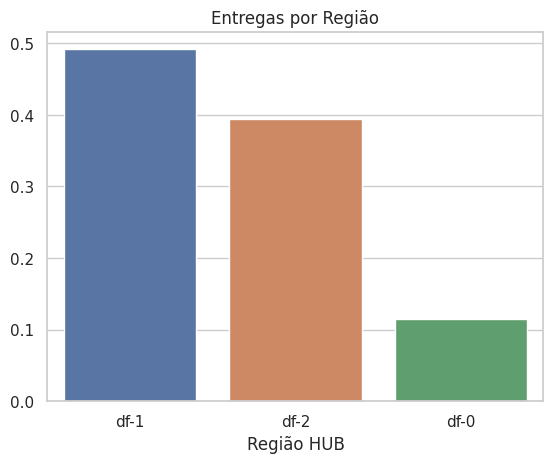

In [ ]:
data = data=deliveries_df[['region']].value_counts(normalize=True).reset_index()
data.rename(columns={0:'percent'}, inplace=True)

sns.set_theme(style="whitegrid")

grafico = sns.barplot(data=data,  x='region', y='percent')
grafico.set(title='Entregas por Região',xlabel='Região HUB', ylabel='')



*   Grande diferença entre a região com mais entregas e com menos entregas
*   df-1 lidera chegando a receber quase 50% de todas as entregas

Como há uma diferença entre a quantidade de entrega entre as regiões, vamos fazer um resumo dos dados da coluna "vehicle_capacity" para ter uma noção da distribuição dos veiculos

In [ ]:
print(f' Máximo {deliveries_df["vehicle_capacity"].max()}')
print(f' Minimo {deliveries_df["vehicle_capacity"].min()}')
print(f' Média {deliveries_df["vehicle_capacity"].mean()}')
print(f' Variância {deliveries_df["vehicle_capacity"].var()}')

 Máximo 180
 Minimo 180
 Média 180.0
 Variância 0.0




*   Nota-se que a concentração de veículos é igual, independente da região de entrega



Vamos agora ir mais afundo, vamos ver quais são as 5 regiões administrativas que mais recebem entregas

[Text(0.5, 1.0, 'Entregas por Região Administrativa'),
 Text(0.5, 0, ''),
 Text(0, 0.5, '')]

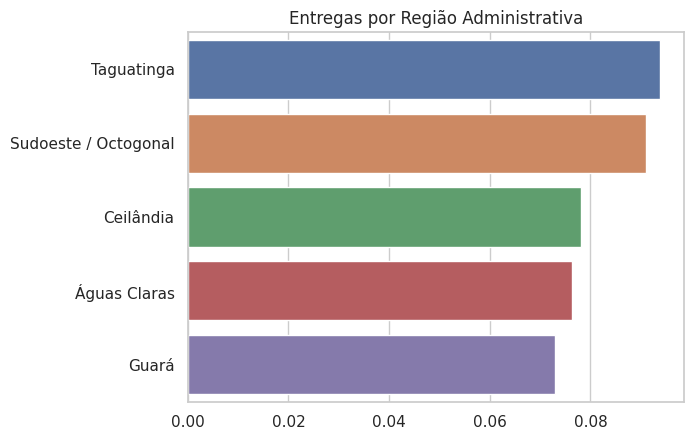

In [ ]:
data = data=deliveries_df[['delivery_city']].value_counts(normalize=True).reset_index()
data.rename(columns={0:'entregas'}, inplace=True)
data = data.nlargest(5, 'entregas')

sns.set_theme(style="whitegrid")

grafico = sns.barplot(data=data,  x='entregas', y='delivery_city')
grafico.set(title='Entregas por Região Administrativa',xlabel='', ylabel='')



*   Baixa diferença entre o primeiro e o segundo lugar, porém, mais de 2% de diferença do quinto lugar



Agora que analisamos parte das entregas, vamos analisar a coluna "delivery_size"

Boxplot do "delivery_size"

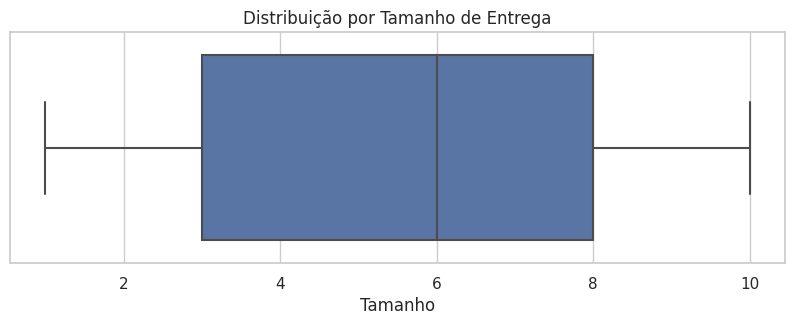

In [ ]:
with sns.axes_style('whitegrid'):
  plt.figure(figsize=(10, 3))
  grafico = sns.boxplot(x=deliveries_df['delivery_size'])
  grafico.set(title='Distribuição por Tamanho de Entrega', xlabel='Tamanho')

Resumo da coluna "delivery_size"

In [ ]:
print(f' Máximo {deliveries_df["delivery_size"].max()}')
print(f' Minimo {deliveries_df["delivery_size"].min()}')
print(f' Média {deliveries_df["delivery_size"].mean().round(1)}')
print(f' Média {deliveries_df["delivery_size"].median().round(1)}')
print(f' Variância {deliveries_df["delivery_size"].var().round(1)}')

 Máximo 10
 Minimo 1
 Média 5.5
 Média 6.0
 Variância 8.3
